## Importamos datos
Dataset de Kaggle: https://www.kaggle.com/c/GiveMeSomeCredit

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('data/cs-training.csv')

df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Limpieza de datos

In [2]:
df.rename(columns = {'SeriousDlqin2yrs': 'target'}, inplace=True)

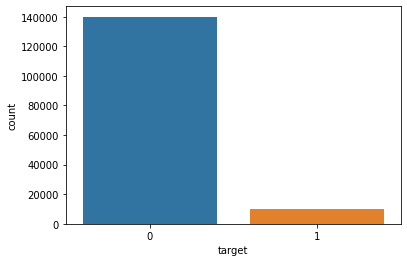

In [3]:
sns.countplot(data=df, x='target');

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   target                                150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [5]:
# Nos cargamos columnas inutiles
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
# Nos cargamos duplicados
df.dropna(inplace=True)

## Matriz de correlación
Vamos a cargarnos algunas columnas que no estén muy relacionadas con el target

In [7]:
np.abs(df.corr()['target']).sort_values(ascending=False)

target                                  1.000000
NumberOfTime30-59DaysPastDueNotWorse    0.123159
NumberOfTimes90DaysLate                 0.111149
age                                     0.102685
NumberOfTime60-89DaysPastDueNotWorse    0.093836
NumberOfDependents                      0.046704
NumberOfOpenCreditLinesAndLoans         0.027445
MonthlyIncome                           0.019746
DebtRatio                               0.003291
NumberRealEstateLoansOrLines            0.003005
RevolvingUtilizationOfUnsecuredLines    0.002386
Name: target, dtype: float64

In [8]:
corr = np.abs(df.corr()['target']).sort_values(ascending=False)

# Features con menos de 0.1 de correlación vs el target
bad_corr_feat = corr[corr < 0.05].index.values

# Filtramos las columnas buenas
df.drop(columns=bad_corr_feat, inplace=True)

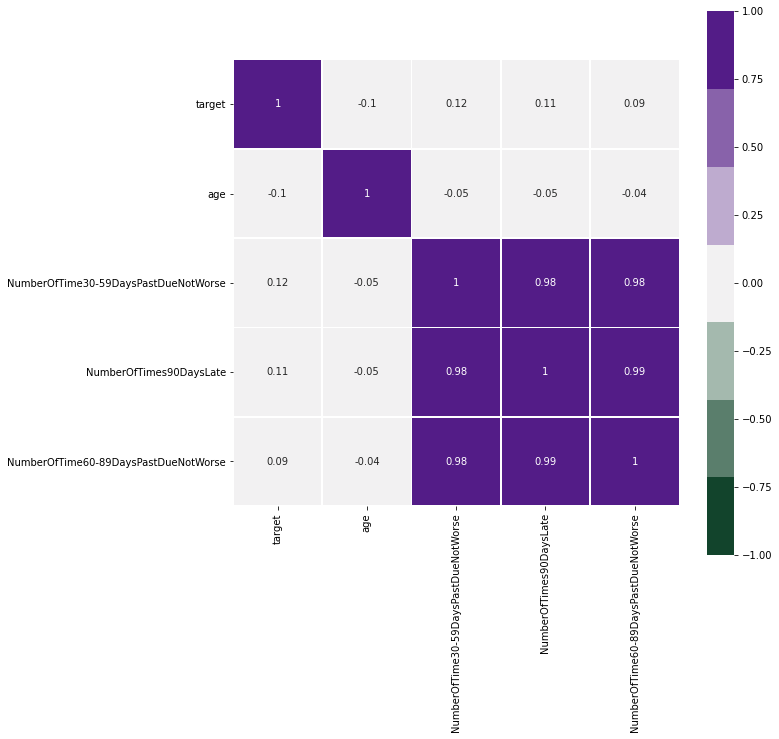

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(np.round(df.corr(), 2),
            vmin=-1,
            vmax=1,
            annot=True,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
            square=True,
            linewidths=.5);

## Dividimos el dataset

In [10]:
from sklearn.model_selection import train_test_split 

X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42) 

## Modelo

In [11]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 5000)

log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [12]:
print(log_reg.coef_)
print(log_reg.intercept_)
print(log_reg.classes_)

[[-0.02789161  0.50545547  0.43901075 -0.9050834 ]]
[-1.46237341]
[0 1]


## Feature importance

In [13]:
intercept = log_reg.intercept_
coefs = log_reg.coef_.ravel()

features = pd.DataFrame(coefs, X_train.columns, columns=['coefficient']).copy()
features['coefficient'] = np.abs(features['coefficient'])

features.sort_values('coefficient', ascending=False).head()

,coefficient
NumberOfTime60-89DaysPastDueNotWorse,0.905083
NumberOfTime30-59DaysPastDueNotWorse,0.505455
NumberOfTimes90DaysLate,0.439011
age,0.027892


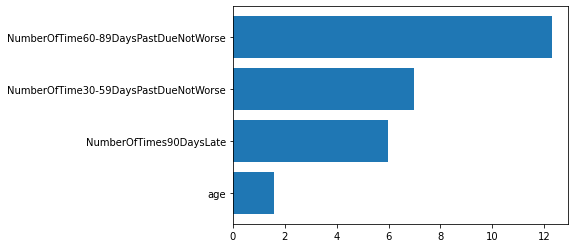

In [14]:
stdevs = []
for i in X_train.columns:
    stdev = df[i].std()
    stdevs.append(stdev)

features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]
features['importance_standarized'] = features['importance'] / y_train.std()

features = features.sort_values('importance_standarized', ascending=True)
plt.barh(features.index, features.importance_standarized);

## Accuracy

In [15]:
from sklearn.metrics import accuracy_score

acc_train = round(accuracy_score(log_reg.predict(X_train), y_train), 3)
acc_test = round(accuracy_score(log_reg.predict(X_test), y_test), 3)

print("Accuracy train:", acc_train)
print("Accuracy train:", acc_train)

Accuracy train: 0.932
Accuracy train: 0.932


## Radial chart

In [16]:
#!pip install yellowbrick

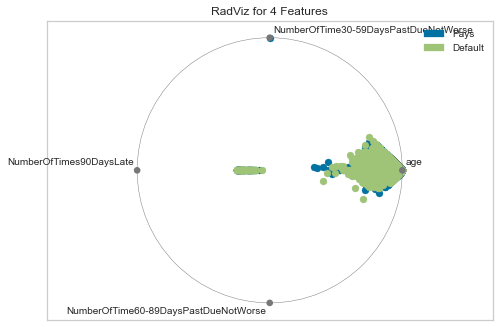

In [17]:
from yellowbrick.features import RadViz
from yellowbrick.features.radviz import radviz

# Specify the target classes
classes = ["Pays", "Default"]

# Instantiate the visualizer
radviz(X, y.values, classes=classes);

## Confusion matrix

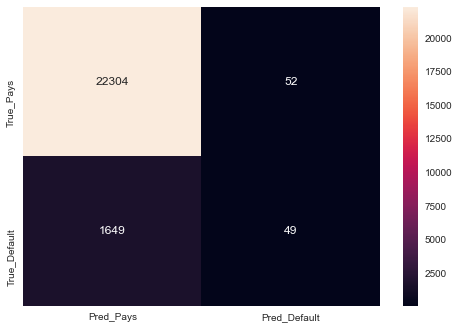

In [18]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_test, log_reg.predict(X_test))

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pays', 'Pred_Default'],
                          index = ['True_Pays', 'True_Default'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');

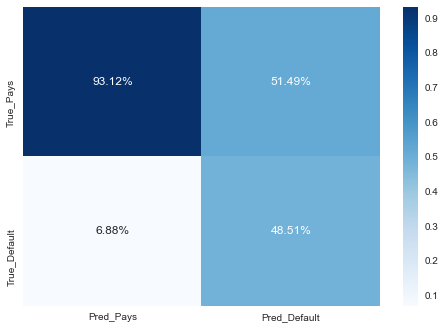

In [19]:
sns.heatmap(c_matrix_df/np.sum(c_matrix_df), annot=True, 
            fmt='.2%', cmap='Blues');

## Prediction errors

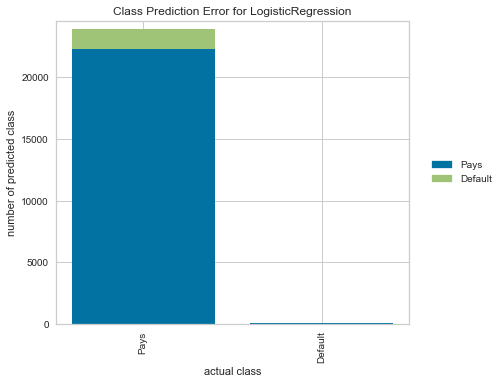

In [20]:
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassPredictionError

classes = ["Pays", "Default"]

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    LogisticRegression(max_iter = 5000), classes=classes
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show();

## Classification report

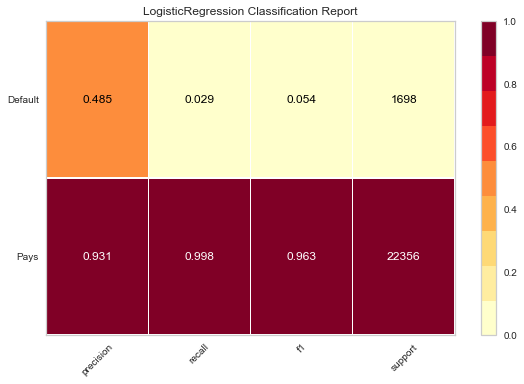

In [21]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import GaussianNB

from yellowbrick.classifier import ClassificationReport
from yellowbrick.datasets import load_occupancy

# Specify the target classes
classes = ["Pays", "Default"]

visualizer = ClassificationReport(LogisticRegression(max_iter = 5000), classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();                       # Finalize and show the figure

## ROC Curve

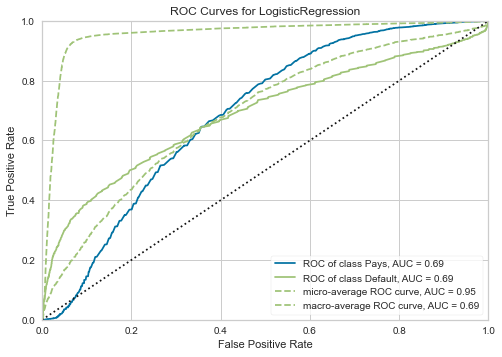

In [22]:
from yellowbrick.classifier import ROCAUC

# Instantiate the visualizer with the classification model
model = LogisticRegression(max_iter = 5000)
classes = ["Pays", "Default"]

visualizer = ROCAUC(model, classes = classes)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();                       # Finalize and show the figure

## Threshold
Lo que realmente hace el `model.predict(X_train)` es obtener una probabilidad de ser 1, y a partir de un 50% se considera como 1. Este umbral del 50% lo podremos ir variando dependiendo de si nos interesa focalizar en los falsos positivos o los falsos negativos.

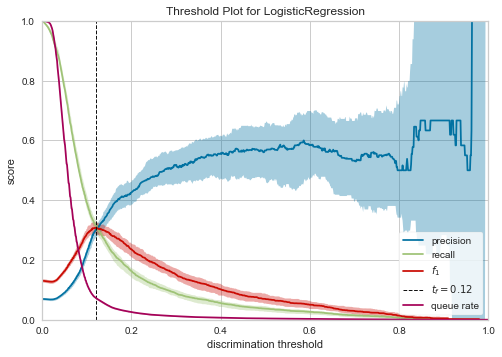

In [23]:
from yellowbrick.classifier import DiscriminationThreshold
import warnings
warnings.filterwarnings('ignore')

# Instantiate the classification model and visualizer
model = LogisticRegression(multi_class="auto", solver="liblinear")
classes = ["Default", "Pays"]

visualizer = DiscriminationThreshold(model)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure

In [24]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

model = LogisticRegression(max_iter = 5000)
model.fit(X_train, y_train)

pred=model.predict_proba(X_test)


def f(punto_corte=0.5):
  y_pred=np.where(pred>punto_corte, 1, 0)
  conf_mat=pd.crosstab(y_test,
                       y_pred[:,1],
                       rownames=['Actual'],
                       colnames=['Predicted'])
    
  sns.heatmap(conf_mat, annot=True, fmt='g')



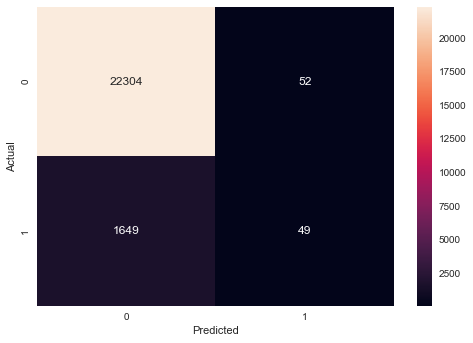

In [25]:
interact(f, punto_corte=(0, 1, 0.01));

## Shap
La librería `shap` también es muy útil para interpretar los modelos. Puedes encontrar información en estos dos artículos

https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

https://towardsdatascience.com/shap-how-to-interpret-machine-learning-models-with-python-2323f5af4be9
